In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from refiners.fluxion.utils import manual_seed, no_grad
from anydoor_refiners.preprocessing import preprocess_images
from anydoor_refiners.postprocessing import post_processing
from anydoor_refiners.model import AnyDoor


torch.set_num_threads(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16

In [ ]:
model = AnyDoor(device=device,dtype=dtype)
model.unet.load_from_safetensors("ckpt/refiners/unet.safetensors")
model.control_model.load_from_safetensors("ckpt/refiners/controlnet.safetensors")
model.object_encoder.load_from_safetensors("ckpt/refiners/dinov2_encoder.safetensors")
model.lda.load_from_safetensors("ckpt/refiners/lda_new.safetensors")
True # suppress output

In [ ]:
seed = 42
uncod_scale = 5.0
num_inference_steps = 50
if num_inference_steps!= model.steps:
    model.set_inference_steps(num_inference_steps, first_step=0)

In [ ]:
from PIL import Image

# File paths
background_image_path = 'examples/background.png'
background_mask_path = 'examples/background_mask.png'
object_image_path = 'examples/object.png'

# Load the object image with alpha channel
object_image = Image.open(object_image_path).convert('RGBA')

# Separate the alpha channel to create the object mask
object_mask = (np.array(object_image.split()[-1]) > 128).astype(np.uint8)

# Remove the alpha channel from the object image and convert to RGB
object_image = object_image.convert('RGB')

# Convert object_image to a NumPy array (RGB only)
object_image = np.array(object_image)

# Load the background image and background mask
background_image = Image.open(background_image_path).convert('RGB')
background_image = np.array(background_image).astype(np.uint8)

background_mask = Image.open(background_mask_path).convert('L')
background_mask = (np.array(background_mask) > 128).astype(np.uint8)


In [ ]:
preprocessed_images = preprocess_images(np.array(object_image), np.array(object_mask), np.array(background_image.copy()), np.array(background_mask))

In [10]:
# background_image_path = 'AnyDoor/examples/Gradio/BG/06.png'
# background_mask_path = 'AnyDoor/examples/TestDreamBooth/BG/000000047948_mask.png'
# object_image_path = 'AnyDoor/examples/TestDreamBooth/FG/01.png'

# File paths
background_image_path = 'examples/backgrounds/5.png'
background_mask_path = 'examples/background_masks/5.png'
object_image_path = 'examples/objects/5.png'


object_image = cv2.imread(object_image_path, cv2.IMREAD_UNCHANGED)
object_mask = (object_image[:,:,-1] > 128).astype(np.uint8)
object_image = object_image[:,:,:-1]
object_image = cv2.cvtColor(object_image.copy(), cv2.COLOR_BGR2RGB)
background_image = cv2.imread(background_image_path).astype(np.uint8)
background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
background_mask = cv2.imread(background_mask_path)[:,:,0] > 128
background_mask = background_mask.astype(np.uint8)

preprocessed_images = preprocess_images(object_image, object_mask, background_image.copy(), background_mask)


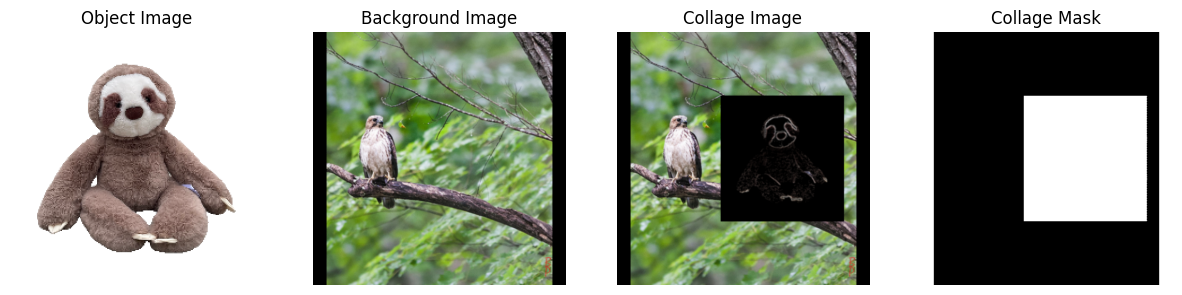

In [11]:
def display_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (title, img) in enumerate(images.items()):
        # Rescale image if it's in the range [-1, 1] to [0, 1]
        if np.min(img) < 0 or np.max(img) > 1:
            img = (img + 1) / 2  # Rescale from [-1, 1] to [0, 1]
        axs[i].imshow(img)
        axs[i].axis("off")
        axs[i].set_title(title)
    plt.show()

display_images({
    "Object Image": preprocessed_images["object"] ,
    "Background Image": preprocessed_images["background"] ,
    "Collage Image": preprocessed_images["collage"][:,:,:-1] ,
    "Collage Mask": np.stack([preprocessed_images["collage"][:,:,-1]] * 3, axis=-1) ,
})

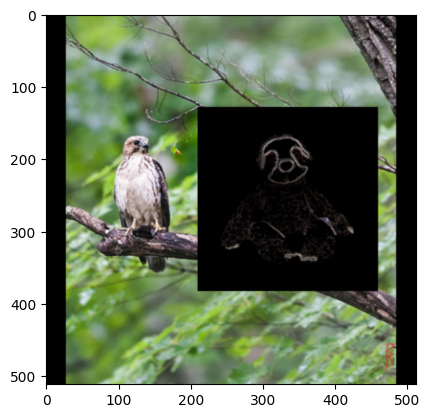

In [15]:
plt.imshow((preprocessed_images["collage"][:,:,:-1]+ 1) / 2)

In [ ]:
control_tensor = torch.from_numpy(preprocessed_images['collage'].copy()).to(device=device,dtype=dtype).unsqueeze(0).permute(0,3,1,2)
object_tensor = torch.from_numpy(preprocessed_images['object'].copy()).to(device=device ,dtype=dtype).unsqueeze(0).permute(0,3,1,2)

In [ ]:
with no_grad():  
    manual_seed(seed)
    object_embedding = model.object_encoder.forward(object_tensor)
    negative_object_embedding = model.object_encoder.forward(torch.zeros((1, 3, 224, 224),device=device,dtype=dtype))
    x = model.init_latents((512, 512))

    for step in tqdm(model.steps):
        x = model.forward(
            x,
            step=step,
            control_background_image= control_tensor,
            object_embedding= object_embedding,
            negative_object_embedding= negative_object_embedding,
            condition_scale= 5.0
        )
    predicted_image = model.lda.latents_to_image(x)

In [ ]:
predicted_image.save("examples/predicted_image.png")

In [3]:
preprocessed_images["sizes"].tolist()

[512, 512, 512, 512]

In [ ]:
import numpy as np
generated_image = post_processing(np.array(predicted_image),background_image,(512,512,512,512),preprocessed_images["background_box"].tolist())

In [ ]:
plt.imshow(generated_image)

In [ ]:
# Save the generated image
cv2.imwrite("examples/generated_image.png", cv2.cvtColor(generated_image, cv2.COLOR_RGB2BGR))